In [1]:
# # install dependencies: 
# !pip3 install pyyaml==5.1 pycocotools>=2.0.1

# !gcc --version
# #opencv is pre-installed on colab

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.6.0 True


In [3]:
# !git clone https://github.com/facebookresearch/detectron2.git

In [4]:
# !python3 -m pip install -e detectron2

In [5]:
# cd detectron2/

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("/home/Desktop/detectron2/balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [3]:
dataset_dicts = get_balloon_dicts("/home/Desktop/detectron2/balloon/train")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow("ww",out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
#trainer.train()

RuntimeError: CUDA error: out of memory

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output1/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[10/11 21:30:16 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[10/11 21:30:16 d2.data.common]: Serialized dataset takes 0.04 MiB
[10/11 21:30:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(0, 0), max_size=1024, sample_style='choice')]
[10/11 21:30:16 d2.evaluation.evaluator]: Start inference on 13 images
[10/11 21:30:21 d2.evaluation.evaluator]: Inference done 11/13. 0.0529 s / img. ETA=0:00:00
[10/11 21:30:22 d2.evaluation.evaluator]: Total inference time: 0:00:02.035423 (0.254428 s / img per device, on 1 devices)
[10/11 21:30:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.053561 s / img per device, on 1 devices)
[10/11 21:30:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/11 21:30:22 d2.evaluation.coco_evaluation]: Saving results to ./output1/coco_instances_results.json
[10/11 21:30:22 d2.evaluation.coco_evaluation]: E

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

RuntimeError: CUDA error: out of memory

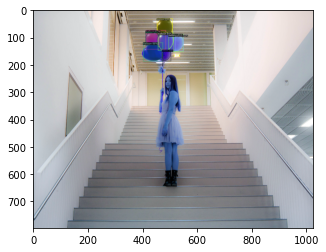

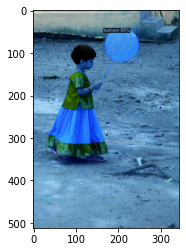

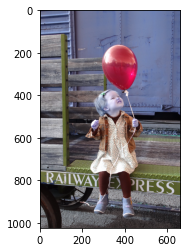

In [18]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("/home/visio-sevgi/Desktop/detectron2/balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     cv2.imshow("l",out.get_image()[:, :, ::-1])
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    plt.figure()
    plt.imshow(out.get_image()[:, :, ::-1]) 
    plt.show()

In [19]:
im = cv2.imread("input/162a.jpg")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#print(im.shape)
from PIL import Image
#im = Image.open("/content/drive/My Drive/162a.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1], 
                scale=0.5)    # remove the colors of unsegmented pixels. This option is only available for segmentation models
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
print(outputs)
cv2.imshow("img",out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("0_162a.jpg",out.get_image()[:, :, ::-1])

RuntimeError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 10.76 GiB total capacity; 7.13 GiB already allocated; 236.44 MiB free; 8.61 GiB reserved in total by PyTorch)

In [14]:
import torch
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

In [22]:
#im = cv2.imread("/home/visio-sevgi/Desktop/my_detectron/162a.jpg")
im = cv2.imread("input/p1.jpg")

#print(im.shape)
from PIL import Image
#im = Image.open("/content/drive/My Drive/162a.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1], 
                scale=0.5)    # remove the colors of unsegmented pixels. This option is only available for segmentation models
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
print(outputs)
cv2.imshow("..1out",out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite("0_162.jpg",out.get_image()[:, :, ::-1])

RuntimeError: CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 10.76 GiB total capacity; 8.53 GiB already allocated; 93.50 MiB free; 8.73 GiB reserved in total by PyTorch)